## Setup

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'had some lovely poetic bits but is really just an artsy-fartsy toss-together with no direction or resolution. how do these people get through film school? who gives them money to make this crap? could have been so much more, fine lead actor, and i always like Fairuza Balk, but come on, the alt-rock metaphor of just staring vacantly unable to find anything compelling is just so tired, and it sure doesn\'t make for good films. the director needs to go away and live life for a good long while and not come back to the camera until they really have something to say. this is like the throw-spaghetti-at-the-wall school of art-making, just juxtapose a bunch of earnest imagery and hope hope hope like hell that poetry emerges. that can work, if the director actually has any kind of vision, or has a brain that knows when it\'s in the presence of potential, but here it\'s just space filler, of no consequence. i felt the lazy ending coming moments before it hit, and was yelling "you lazy

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 67,  47,   1, ...,   0,   0,   0],
       [ 10, 341,   6, ...,   0,   0,   0],
       [  2,   1,   1, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [11]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'had some lovely poetic bits but is really just an artsy-fartsy toss-together with no direction or resolution. how do these people get through film school? who gives them money to make this crap? could have been so much more, fine lead actor, and i always like Fairuza Balk, but come on, the alt-rock metaphor of just staring vacantly unable to find anything compelling is just so tired, and it sure doesn\'t make for good films. the director needs to go away and live life for a good long while and not come back to the camera until they really have something to say. this is like the throw-spaghetti-at-the-wall school of art-making, just juxtapose a bunch of earnest imagery and hope hope hope like hell that poetry emerges. that can work, if the director actually has any kind of vision, or has a brain that knows when it\'s in the presence of potential, but here it\'s just space filler, of no consequence. i felt the lazy ending coming moments before it hit, and was yelling "you la

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [14]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 9s 9s/step
[0.0117404]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [15]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 105ms/step
[0.0117404]


Compile the Keras model to configure the training process:

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 52s 103ms/step - loss: 0.6302 - accuracy: 0.5804 - val_loss: 0.5048 - val_accuracy: 0.7240
Epoch 2/10
391/391 [==============================] - 32s 80ms/step - loss: 0.4271 - accuracy: 0.8008 - val_loss: 0.4134 - val_accuracy: 0.8161
Epoch 3/10
391/391 [==============================] - 25s 65ms/step - loss: 0.3661 - accuracy: 0.8322 - val_loss: 0.3614 - val_accuracy: 0.8391
Epoch 4/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3361 - accuracy: 0.8523 - val_loss: 0.3527 - val_accuracy: 0.8573
Epoch 5/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3210 - accuracy: 0.8610 - val_loss: 0.3398 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3136 - accuracy: 0.8646 - val_loss: 0.3297 - val_accuracy: 0.8526
Epoch 7/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3069 - accuracy: 0.8687 - val_loss: 0.3259 - val_accuracy

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 13s 34ms/step - loss: 0.3248 - accuracy: 0.8612
Test Loss: 0.32478639483451843
Test Accuracy: 0.861240029335022


(0.0, 0.6468004554510116)

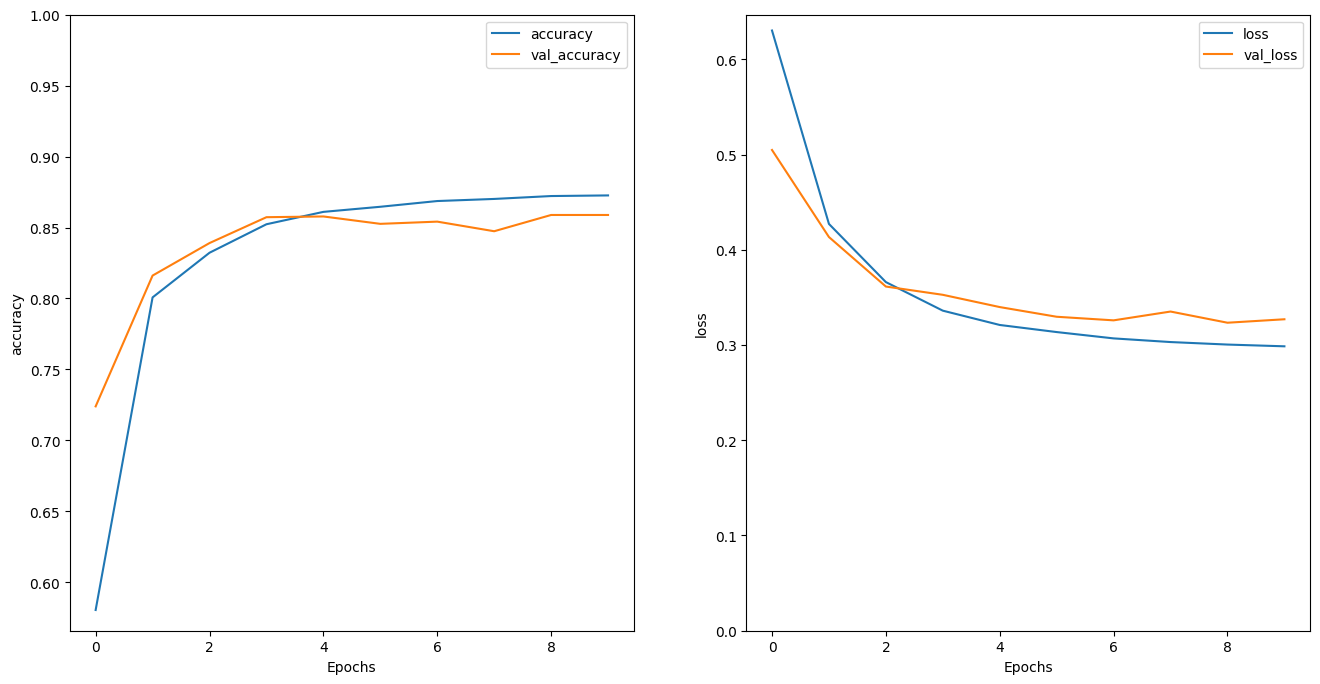

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 44ms/step
[[0.98215336]]
